In [1]:
import meep as mp
import math

Using MPI version 4.0, 1 processes


In [2]:
resolution = 200
theta = 5

In [3]:
dpml = 1.0              # PML thickness
sz = 10 + 2*dpml        # size of cell (without PMLs)
cell_size = mp.Vector3(0,0,sz)
pml_layers = [mp.PML(dpml)]

wvl_min = 0.4           # min wavelength
wvl_max = 0.8           # max wavelength
fmin = 1/wvl_max        # min frequency
fmax = 1/wvl_min        # max frequency
fcen = 0.5*(fmin+fmax)  # center frequency
df = fmax-fmin          # frequency width
nfreq = 50              # number of frequency bins

# rotation angle (in degrees) of source: CCW around Y axis, 0 degrees along +Z axis
theta_r = math.radians(theta)

# plane of incidence is xz
k = mp.Vector3(math.sin(theta_r),0,math.cos(theta_r)).scale(fmin)

# if normal incidence, force number of dimensions to be 1
if theta_r == 0:
    dimensions = 1
else:
    dimensions = 3

sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                        component=mp.Ex,
                        center=mp.Vector3(0,0,-0.5*sz+dpml))]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    sources=sources,
                    k_point=k,
                    dimensions=dimensions,
                    resolution=resolution)

refl_fr = mp.FluxRegion(center=mp.Vector3(0,0,-0.25*sz))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

/home/gridsan/mcomella/.conda/envs/pmp/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gridsan/mcomella/.conda/envs/pmp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gridsan/mcomella/.conda/envs/pmp/lib/python3.10/site-packages/meep/visualization.py:216: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn('The specified user volume is larger than the simulation domain and has been truncated.')


ValueError: Axes=(0, 1) out of range for array of ndim=0.

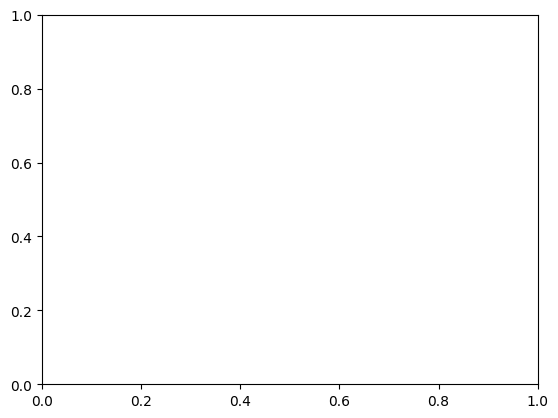

In [4]:
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(sz,sz)))

ValueError: Axes must be different.

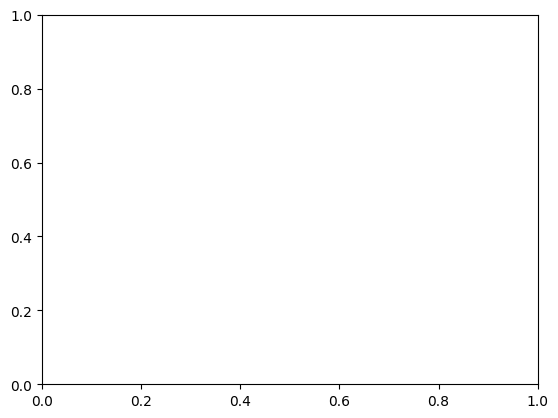

In [ ]:
sim.plot2D()

In [ ]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(0,0,-0.5*sz+dpml), 1e-9))

empty_flux = mp.get_fluxes(refl)
empty_data = sim.get_flux_data(refl)
sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00303078 s
Working in 3D dimensions.
Computational cell is 0.005 x 0.005 x 12 with resolution 200
time for set_epsilon = 0.0202432 s
-----------
Meep: using complex fields.
on time step 10003 (time=25.0075), 0.000399909 s/step
field decay(t = 50.0025): 0.2493482491697244 / 0.2493482491697244 = 1.0
on time step 20591 (time=51.4775), 0.000377814 s/step
on time step 30980 (time=77.45), 0.000385057 s/step
field decay(t = 100.0025): 4.464698828605439e-14 / 0.2493482491697244 = 1.7905474947074695e-13
run 0 finished at t = 100.0025 (40001 timesteps)


In [ ]:
# add a block with n=3.5 for the air-dielectric interface
geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,0.5*sz),
                        center=mp.Vector3(0,0,0.25*sz),
                        material=mp.Medium(index=3.5))]

sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=sources,
                    k_point=k,
                    dimensions=dimensions,
                    resolution=resolution)

refl = sim.add_flux(fcen, df, nfreq, refl_fr)
sim.load_minus_flux_data(refl, empty_data)


-----------
Initializing structure...
time for choose_chunkdivision = 0.00274205 s
Working in 3D dimensions.
Computational cell is 0.005 x 0.005 x 12 with resolution 200
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.25,12.25,12.25)
time for set_epsilon = 0.0348768 s
-----------
Meep: using complex fields.


In [ ]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(0,0,-0.5*sz+dpml), 1e-9))

refl_flux = mp.get_fluxes(refl)
freqs = mp.get_flux_freqs(refl)

on time step 9368 (time=23.42), 0.000427015 s/step
on time step 19478 (time=48.695), 0.000395672 s/step
field decay(t = 50.0025): 0.24934824909392067 / 0.24934824909392067 = 1.0
on time step 29443 (time=73.6075), 0.000401443 s/step
on time step 39331 (time=98.3275), 0.000404537 s/step
field decay(t = 100.0025): 4.0715782407411667e-13 / 0.24934824909392067 = 1.6328882418611037e-12
run 0 finished at t = 100.0025 (40001 timesteps)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import math

theta_in = np.arange(0,85,5)
kxs = np.empty((50,theta_in.size))
thetas = np.empty((50,theta_in.size))
Rmeep = np.empty((50,theta_in.size))

for j in range(theta_in.size):
  f = np.genfromtxt("flux_t{}.dat".format(theta_in[j]), delimiter=",")
  kxs[:,j] = f[:,0]
  thetas[:,j] = f[:,2]
  Rmeep[:,j] = f[:,3]

wvl = f[:,1]
# create a 2d matrix for the wavelength by repeating the column vector for each angle
wvls = np.matlib.repmat(np.reshape(wvl, (wvl.size,1)),1,theta_in.size)

plt.figure()
plt.pcolormesh(kxs, wvls, Rmeep, cmap='hot', shading='gouraud', vmin=0, vmax=Rmeep.max())
plt.axis([kxs[0,0], kxs[0,-1], wvl[-1], wvl[0]])
plt.yticks([t for t in np.arange(0.4,0.9,0.1)])
plt.xlabel("Bloch-periodic wavevector ($k_x/2π$)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (meep)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.arange(0,0.4,0.1)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.arange(0,0.4,0.1)])
plt.show()

plt.figure()
plt.pcolormesh(thetas, wvls, Rmeep, cmap='hot', shading='gouraud', vmin=0, vmax=Rmeep.max())
plt.axis([thetas.min(), thetas.max(), wvl[-1], wvl[0]])
plt.xticks([t for t in range(0,100,20)])
plt.yticks([t for t in np.arange(0.4,0.9,0.1)])
plt.xlabel("angle of incident planewave (degrees)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (meep)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.arange(0,0.4,0.1)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.arange(0,0.4,0.1)])
plt.show()

n1=1
n2=3.5

# compute angle of refracted planewave in medium n2
# for incident planewave in medium n1 at angle theta_in
theta_out = lambda theta_in: math.asin(n1*math.sin(theta_in)/n2)

# compute Fresnel reflectance for P-polarization in medium n2
# for incident planewave in medium n1 at angle theta_in
Rfresnel = lambda theta_in: math.fabs((n1*math.cos(theta_out(theta_in))-n2*math.cos(theta_in))/(n1*math.cos(theta_out(theta_in))+n2*math.cos(theta_in)))**2

Ranalytic = np.empty((50, theta_in.size))
for m in range(wvl.size):
    for n in range(theta_in.size):
        Ranalytic[m,n] = Rfresnel(math.radians(thetas[m,n]))

plt.figure()
plt.pcolormesh(thetas, wvls, Ranalytic, cmap='hot', shading='gouraud', vmin=0, vmax=Ranalytic.max())
plt.axis([thetas.min(), thetas.max(), wvl[-1], wvl[0]])
plt.xticks([t for t in range(0,100,20)])
plt.yticks([t for t in np.arange(0.4,0.9,0.1)])
plt.xlabel("angle of incident planewave (degrees)")
plt.ylabel("wavelength (μm)")
plt.title("reflectance (analytic)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.arange(0,0.4,0.1)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.arange(0,0.4,0.1)])
plt.show()

FileNotFoundError: flux_t0.dat not found.

---

In [5]:
import meep as mp
import math
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

resolution = 50  # pixels/um

dpml = 1.0  # PML thickness
sz = 10 + 2 * dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]

wvl_min = 0.4  # min wavelength
wvl_max = 0.8  # max wavelength
fmin = 1 / wvl_max  # min frequency
fmax = 1 / wvl_min  # max frequency
fcen = 0.5 * (fmin + fmax)  # center frequency
df = fmax - fmin  # frequency width
nfreq = 50  # number of frequency bins


def planar_reflectance(theta):
    # rotation angle (in degrees) of source: CCW around Y axis, 0 degrees along +Z axis
    theta_r = math.radians(theta)

    # plane of incidence is XZ; rotate counter clockwise (CCW) about y-axis
    k = mp.Vector3(z=fmin).rotate(mp.Vector3(y=1), theta_r)

    # if normal incidence, force number of dimensions to be 1
    if theta_r == 0:
        dimensions = 1
    else:
        dimensions = 3

    sources = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ex,
            center=mp.Vector3(z=-0.5 * sz + dpml),
        )
    ]

    sim = mp.Simulation(
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=k,
        dimensions=dimensions,
        resolution=resolution,
    )

    refl_fr = mp.FluxRegion(center=mp.Vector3(z=-0.25 * sz))
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ex, mp.Vector3(z=-0.5 * sz + dpml), 1e-9
        )
    )

    empty_flux = mp.get_fluxes(refl)
    empty_data = sim.get_flux_data(refl)

    sim.reset_meep()

    # add a block with n=3.5 for the air-dielectric interface
    geometry = [
        mp.Block(
            mp.Vector3(mp.inf, mp.inf, 0.5 * sz),
            center=mp.Vector3(z=0.25 * sz),
            material=mp.Medium(index=3.5),
        )
    ]

    sim = mp.Simulation(
        cell_size=cell_size,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=k,
        dimensions=dimensions,
        resolution=resolution,
    )

    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    sim.load_minus_flux_data(refl, empty_data)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ex, mp.Vector3(z=-0.5 * sz + dpml), 1e-9
        )
    )

    refl_flux = mp.get_fluxes(refl)
    freqs = mp.get_flux_freqs(refl)

    wvls = np.empty(nfreq)
    theta_out = np.empty(nfreq)
    R = np.empty(nfreq)
    for i in range(nfreq):
        wvls[i] = 1 / freqs[i]
        theta_out[i] = math.degrees(math.asin(k.x / freqs[i]))
        R[i] = -refl_flux[i] / empty_flux[i]
        print("refl:, {}, {}, {}, {}".format(k.x, wvls[i], theta_out[i], R[i]))

    return k.x * np.ones(nfreq), wvls, theta_out, R
